In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import os
from joblib import dump, load

def save_checkpoint(model, filename):
    """Salva o modelo (checkpoint) em um arquivo."""
    dump(model, filename)
    print(f"Checkpoint salvo em: {filename}")



In [3]:
def load_checkpoint(filename):
    """Carrega um modelo (checkpoint) salvo em um arquivo."""
    model = load(filename)
    print(f"Checkpoint carregado de: {filename}")
    return model


In [4]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LinearRegression, Perceptron


data = pd.read_csv('data/smoking_driking_dataset_Ver01.csv')

print(data.head())




    sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0  Male   35     170      75       90.0         1.0          1.0        1.0   
1  Male   30     180      80       89.0         0.9          1.2        1.0   
2  Male   40     165      75       91.0         1.2          1.5        1.0   
3  Male   50     175      80       91.0         1.5          1.2        1.0   
4  Male   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  LDL_chole  triglyceride  hemoglobin  urine_protein  \
0         1.0  120.0  ...      126.0          92.0        17.1            1.0   
1         1.0  130.0  ...      148.0         121.0        15.8            1.0   
2         1.0  120.0  ...       74.0         104.0        15.8            1.0   
3         1.0  145.0  ...      104.0         106.0        17.6            1.0   
4         1.0  138.0  ...      117.0         104.0        13.8            1.0   

   serum_creatinine  SGOT_AST  SGOT_AL

In [5]:

# Mapeamento da coluna 'sex' para 0 e 1. 
# Considera os valores: "masculino"/"feminino" e "Male"/"Female"
data['sex'] = data['sex'].map({'masculino': 0, 'feminino': 1, 'Male': 0, 'Female': 1})

# Se a coluna alvo "DRK_YN" estiver em formato texto ("Y"/"N"), convertemos para numérico
le = LabelEncoder()
data['DRK_YN'] = le.fit_transform(data['DRK_YN'])
# Exemplo: 0 = não bebe, 1 = bebe

# Visualizando estatísticas do dataset
print(data.describe())



                 sex            age         height         weight  \
count  991346.000000  991346.000000  991346.000000  991346.000000   
mean        0.468990      47.614491     162.240625      63.284050   
std         0.499038      14.181339       9.282957      12.514241   
min         0.000000      20.000000     130.000000      25.000000   
25%         0.000000      35.000000     155.000000      55.000000   
50%         0.000000      45.000000     160.000000      60.000000   
75%         1.000000      60.000000     170.000000      70.000000   
max         1.000000      85.000000     190.000000     140.000000   

           waistline     sight_left    sight_right      hear_left  \
count  991346.000000  991346.000000  991346.000000  991346.000000   
mean       81.233358       0.980834       0.978429       1.031495   
std        11.850323       0.605949       0.604774       0.174650   
min         8.000000       0.100000       0.100000       1.000000   
25%        74.100000       0.7000

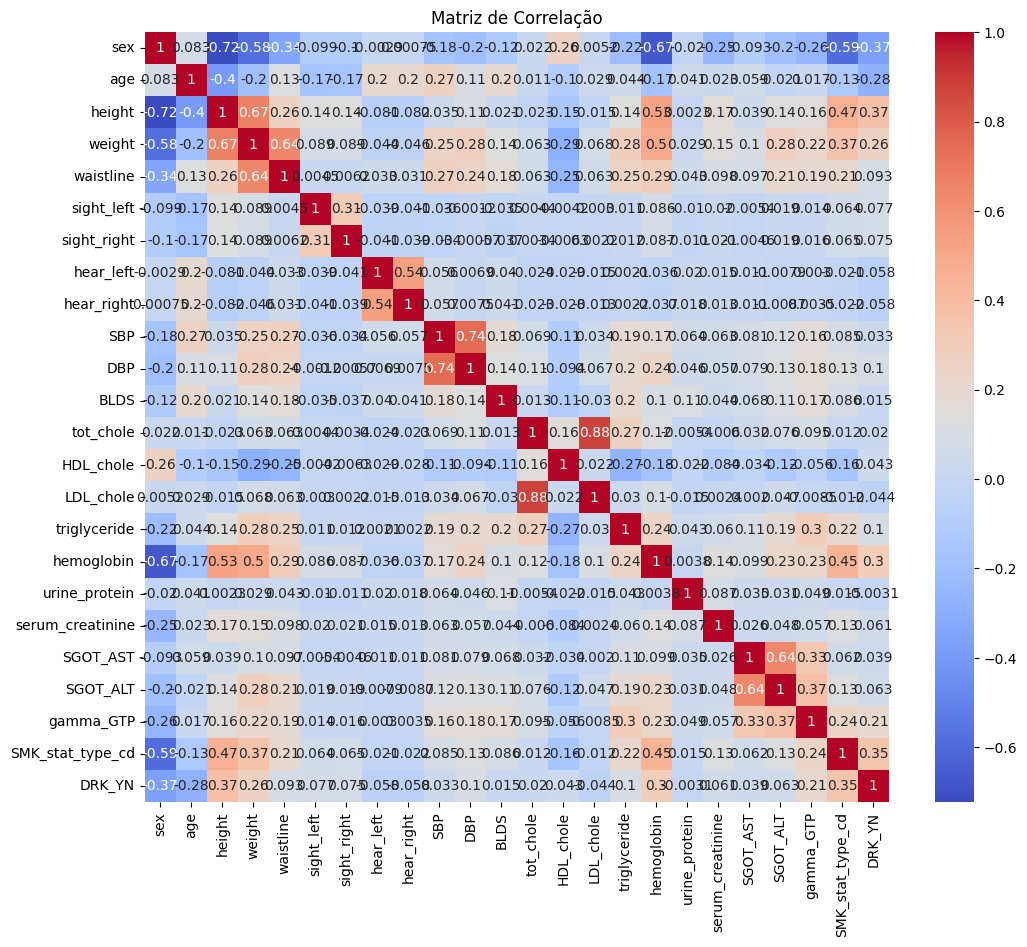

In [6]:
# ------------------------------
# Análise de correlação (KDD)
# ------------------------------
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()



In [7]:
# ------------------------------
# Tratamento de valores faltantes
# ------------------------------

# 1. Imputação para colunas categóricas (para as colunas que serão usadas no Categorical NB)
categorical_features = ['sex', 'hear_left', 'hear_right', 'urine_protein', 'SMK_stat_type_cd']
print("Valores nulos nos atributos categóricos:")
print(data[categorical_features].isnull().sum())

for col in categorical_features:
    if data[col].isnull().sum() > 0:
        mode_series = data[col].mode()
        if not mode_series.empty:
            mode_val = mode_series.iloc[0]
        else:
            mode_val = 0  # valor default, se não houver moda
        data[col] = data[col].fillna(mode_val)
        print(f"Coluna '{col}': preenchendo NaNs com: {mode_val}")

print("\nValores nulos após imputação categórica:")
print(data[categorical_features].isnull().sum())



Valores nulos nos atributos categóricos:
sex                 0
hear_left           0
hear_right          0
urine_protein       0
SMK_stat_type_cd    0
dtype: int64

Valores nulos após imputação categórica:
sex                 0
hear_left           0
hear_right          0
urine_protein       0
SMK_stat_type_cd    0
dtype: int64


In [8]:
# 2. Imputação para colunas numéricas (todas as colunas numéricas em X)
# Definindo features e target
X = data.drop('DRK_YN', axis=1)
y = data['DRK_YN']

# Seleciona colunas numéricas
numeric_features = X.select_dtypes(include=[np.number]).columns
# Cria um imputer para preencher NaNs com a média
imputer = SimpleImputer(strategy='mean')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Verifica se ainda há NaNs
if X.isnull().sum().sum() == 0:
    print("\nTodos os valores faltantes foram tratados em X.")
else:
    print("\nAinda há valores faltantes em X:")
    print(X.isnull().sum())




Todos os valores faltantes foram tratados em X.


In [9]:
# ------------------------------
# 2. Dividindo os dados em treino e teste
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# 3. Definição dos modelos
# ------------------------------

# 1.1. Árvore de Decisão CART (padrão)
model_dt = DecisionTreeClassifier(random_state=42)





In [10]:
# # 1.3. SVM (Kernel Linear)
# model_svm_linear = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))

# 1.4. KNN (padrão, k=5 por padrão)
model_knn_default = make_pipeline(StandardScaler(), KNeighborsClassifier())

# 1.5. KNN com k alterado (exemplo: k = 10)
model_knn_k10 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10))

# 1.6. KNN com medida de distância alterada (exemplo: distância Manhattan)
model_knn_manhattan = make_pipeline(StandardScaler(), KNeighborsClassifier(metric='manhattan'))

# 1.7. Gaussian Naive Bayes (padrão)
model_gnb = GaussianNB()



In [11]:
# 1.8. Categorical Naive Bayes (padrão)
X_cat = data[categorical_features].apply(lambda x: x.astype('int'))
print("\nTipos de dados após conversão das colunas categóricas:")
print(X_cat.dtypes)
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y, test_size=0.2, random_state=42)
model_cnb = CategoricalNB()

# 1.9. Regressão Linear (quadrados mínimos)
model_lr = make_pipeline(StandardScaler(), LinearRegression())

# 1.10. Perceptron
model_perceptron = make_pipeline(StandardScaler(), Perceptron(random_state=42))




Tipos de dados após conversão das colunas categóricas:
sex                 int32
hear_left           int32
hear_right          int32
urine_protein       int32
SMK_stat_type_cd    int32
dtype: object


In [12]:
# ------------------------------
# 4. Função para avaliação
# ------------------------------
def evaluate_classifier(model, X_tr, X_te, y_tr, y_te, model_name, checkpoint_filename):
    """
    Treina ou carrega o modelo via checkpoint, faz predições e exibe métricas.
    Se o arquivo de checkpoint existir, carrega o modelo; caso contrário, treina o modelo e salva o checkpoint.
    """
    if os.path.exists(checkpoint_filename):
        model = load_checkpoint(checkpoint_filename)
        print(f"{model_name} - Modelo carregado do checkpoint.")
    else:
        model.fit(X_tr, y_tr)
        save_checkpoint(model, checkpoint_filename)
        print(f"{model_name} - Modelo treinado e salvo no checkpoint.")
        
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"{model_name} - Acurácia: {acc:.4f}")
    print(classification_report(y_te, y_pred))
    print("Matriz de Confusão:")
    print(confusion_matrix(y_te, y_pred))
    print("-"*50)



In [13]:
def evaluate_regression_classifier(model, X_tr, X_te, y_tr, y_te, model_name, checkpoint_filename, threshold=0.5):
    """
    Treina ou carrega o modelo de regressão via checkpoint, faz predições,
    converte as predições contínuas em classes utilizando o threshold, e exibe métricas.
    """
    if os.path.exists(checkpoint_filename):
        model = load_checkpoint(checkpoint_filename)
        print(f"{model_name} - Modelo carregado do checkpoint.")
    else:
        model.fit(X_tr, y_tr)
        save_checkpoint(model, checkpoint_filename)
        print(f"{model_name} - Modelo treinado e salvo no checkpoint.")
        
    y_pred = model.predict(X_te)
    # Converter as predições contínuas para classes usando o threshold
    y_pred_class = [1 if pred >= threshold else 0 for pred in y_pred]
    acc = accuracy_score(y_te, y_pred_class)
    print(f"{model_name} - Acurácia: {acc:.4f}")
    print(classification_report(y_te, y_pred_class))
    print("Matriz de Confusão:")
    print(confusion_matrix(y_te, y_pred_class))
    print("-"*50)



In [14]:
print("=== 1.1. Árvore de Decisão (CART) ===")
evaluate_classifier(model_dt, X_train, X_test, y_train, y_test, "Árvore de Decisão", "model_dt.joblib")



=== 1.1. Árvore de Decisão (CART) ===
Checkpoint carregado de: model_dt.joblib
Árvore de Decisão - Modelo carregado do checkpoint.
Árvore de Decisão - Acurácia: 0.6458
              precision    recall  f1-score   support

           0       0.65      0.64      0.65     99595
           1       0.64      0.65      0.65     98675

    accuracy                           0.65    198270
   macro avg       0.65      0.65      0.65    198270
weighted avg       0.65      0.65      0.65    198270

Matriz de Confusão:
[[64132 35463]
 [34771 63904]]
--------------------------------------------------


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.calibration import LinearSVC

# 1.2 SVM padrão (Kernel RBF)
model_svm_rbf = SVC(kernel='rbf', C=1.0, max_iter=10000,gamma='scale', verbose=1)
evaluate_classifier(model_svm_rbf, X_train_scaled, X_test_scaled, y_train, y_test, 
                    "SVM (Kernel RBF - Padrão)", "model_svm_rbf.joblib")



Checkpoint carregado de: model_svm_rbf.joblib
SVM (Kernel RBF - Padrão) - Modelo carregado do checkpoint.
SVM (Kernel RBF - Padrão) - Acurácia: 0.3769
              precision    recall  f1-score   support

           0       0.39      0.42      0.40     99595
           1       0.36      0.34      0.35     98675

    accuracy                           0.38    198270
   macro avg       0.38      0.38      0.38    198270
weighted avg       0.38      0.38      0.38    198270

Matriz de Confusão:
[[41349 58246]
 [65297 33378]]
--------------------------------------------------


In [17]:
# 1.3 SVM mudando o kernel para linear (ou outro de sua preferência)
model_svm_linear = LinearSVC(C=1.0, max_iter=10000, verbose=1)
evaluate_classifier(model_svm_linear, X_train_scaled, X_test_scaled, y_train, y_test, 
                    "SVM Linear", "model_svm_linear.joblib")

Checkpoint carregado de: model_svm_linear.joblib
SVM Linear - Modelo carregado do checkpoint.
SVM Linear - Acurácia: 0.7228
              precision    recall  f1-score   support

           0       0.72      0.73      0.73     99595
           1       0.72      0.71      0.72     98675

    accuracy                           0.72    198270
   macro avg       0.72      0.72      0.72    198270
weighted avg       0.72      0.72      0.72    198270

Matriz de Confusão:
[[72806 26789]
 [28179 70496]]
--------------------------------------------------


In [18]:


print("=== 1.4. KNN (Padrão) ===")
evaluate_classifier(model_knn_default, X_train, X_test, y_train, y_test, "KNN Padrão", "model_knn_default.joblib")


=== 1.4. KNN (Padrão) ===
Checkpoint carregado de: model_knn_default.joblib
KNN Padrão - Modelo carregado do checkpoint.
KNN Padrão - Acurácia: 0.6884
              precision    recall  f1-score   support

           0       0.70      0.67      0.69     99595
           1       0.68      0.70      0.69     98675

    accuracy                           0.69    198270
   macro avg       0.69      0.69      0.69    198270
weighted avg       0.69      0.69      0.69    198270

Matriz de Confusão:
[[67185 32410]
 [29362 69313]]
--------------------------------------------------


In [19]:

print("=== 1.5. KNN (k = 10) ===")
evaluate_classifier(model_knn_k10, X_train, X_test, y_train, y_test, "KNN k=10", "model_knn_k10.joblib")


=== 1.5. KNN (k = 10) ===
Checkpoint carregado de: model_knn_k10.joblib
KNN k=10 - Modelo carregado do checkpoint.
KNN k=10 - Acurácia: 0.7033
              precision    recall  f1-score   support

           0       0.69      0.74      0.71     99595
           1       0.72      0.67      0.69     98675

    accuracy                           0.70    198270
   macro avg       0.70      0.70      0.70    198270
weighted avg       0.70      0.70      0.70    198270

Matriz de Confusão:
[[73417 26178]
 [32646 66029]]
--------------------------------------------------


In [20]:

print("=== 1.6. KNN (Distância Manhattan) ===")
evaluate_classifier(model_knn_manhattan, X_train, X_test, y_train, y_test, "KNN Manhattan", "model_knn_manhattan.joblib")


=== 1.6. KNN (Distância Manhattan) ===
Checkpoint carregado de: model_knn_manhattan.joblib
KNN Manhattan - Modelo carregado do checkpoint.
KNN Manhattan - Acurácia: 0.6895
              precision    recall  f1-score   support

           0       0.70      0.68      0.69     99595
           1       0.68      0.70      0.69     98675

    accuracy                           0.69    198270
   macro avg       0.69      0.69      0.69    198270
weighted avg       0.69      0.69      0.69    198270

Matriz de Confusão:
[[67638 31957]
 [29605 69070]]
--------------------------------------------------


In [21]:

print("=== 1.7. Gaussian Naive Bayes ===")
evaluate_classifier(model_gnb, X_train, X_test, y_train, y_test, "Gaussian NB", "model_gnb.joblib")



=== 1.7. Gaussian Naive Bayes ===
Checkpoint carregado de: model_gnb.joblib
Gaussian NB - Modelo carregado do checkpoint.
Gaussian NB - Acurácia: 0.6914
              precision    recall  f1-score   support

           0       0.69      0.71      0.70     99595
           1       0.70      0.67      0.69     98675

    accuracy                           0.69    198270
   macro avg       0.69      0.69      0.69    198270
weighted avg       0.69      0.69      0.69    198270

Matriz de Confusão:
[[70528 29067]
 [32110 66565]]
--------------------------------------------------


In [22]:
print("=== 1.8. Categorical Naive Bayes ===")
categorical_checkpoint = "categorical_nb_checkpoint.joblib"
evaluate_classifier(model_cnb, X_cat_train, X_cat_test, y_cat_train, y_cat_test, 
                    "Categorical NB", categorical_checkpoint)



=== 1.8. Categorical Naive Bayes ===
Checkpoint carregado de: categorical_nb_checkpoint.joblib
Categorical NB - Modelo carregado do checkpoint.
Categorical NB - Acurácia: 0.6918
              precision    recall  f1-score   support

           0       0.71      0.64      0.68     99595
           1       0.67      0.74      0.71     98675

    accuracy                           0.69    198270
   macro avg       0.69      0.69      0.69    198270
weighted avg       0.69      0.69      0.69    198270

Matriz de Confusão:
[[64082 35513]
 [25591 73084]]
--------------------------------------------------


In [23]:
print("=== 1.9. Regressão Linear (com threshold 0.5) ===")
regression_checkpoint = "linear_regression_checkpoint.joblib"
evaluate_regression_classifier(model_lr, X_train, X_test, y_train, y_test, 
                               "Regressão Linear", regression_checkpoint, threshold=0.5)



=== 1.9. Regressão Linear (com threshold 0.5) ===
Checkpoint carregado de: linear_regression_checkpoint.joblib
Regressão Linear - Modelo carregado do checkpoint.
Regressão Linear - Acurácia: 0.7206
              precision    recall  f1-score   support

           0       0.72      0.73      0.72     99595
           1       0.72      0.71      0.72     98675

    accuracy                           0.72    198270
   macro avg       0.72      0.72      0.72    198270
weighted avg       0.72      0.72      0.72    198270

Matriz de Confusão:
[[72460 27135]
 [28271 70404]]
--------------------------------------------------


In [24]:
print("=== 1.10. Perceptron ===")
evaluate_classifier(model_perceptron, X_train, X_test, y_train, y_test, "Perceptron", "model_perceptron.joblib")

=== 1.10. Perceptron ===
Checkpoint carregado de: model_perceptron.joblib
Perceptron - Modelo carregado do checkpoint.
Perceptron - Acurácia: 0.6990
              precision    recall  f1-score   support

           0       0.69      0.73      0.71     99595
           1       0.71      0.66      0.69     98675

    accuracy                           0.70    198270
   macro avg       0.70      0.70      0.70    198270
weighted avg       0.70      0.70      0.70    198270

Matriz de Confusão:
[[72984 26611]
 [33064 65611]]
--------------------------------------------------


In [25]:

print("\n=== 6. RandomForestClassifier - Importância das Variáveis ===")
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
print("Importância das variáveis (RandomForest):")
print(feature_importance_df)



=== 6. RandomForestClassifier - Importância das Variáveis ===
Importância das variáveis (RandomForest):
             feature  importance
21         gamma_GTP    0.077101
1                age    0.067194
16        hemoglobin    0.064636
13         HDL_chole    0.060847
15      triglyceride    0.056710
2             height    0.056516
22  SMK_stat_type_cd    0.052821
14         LDL_chole    0.052624
12         tot_chole    0.051828
11              BLDS    0.050185
20          SGOT_ALT    0.049749
4          waistline    0.049473
9                SBP    0.046215
0                sex    0.045709
19          SGOT_AST    0.043652
10               DBP    0.043525
3             weight    0.032171
18  serum_creatinine    0.030383
5         sight_left    0.030150
6        sight_right    0.029722
17     urine_protein    0.005050
7          hear_left    0.001898
8         hear_right    0.001838


In [26]:

# 7. Remover variáveis de baixa importância e re-treinar
threshold = 0.005
low_importance_features = feature_importance_df[feature_importance_df['importance'] < threshold]['feature'].tolist()

print(f"\nRemovendo variáveis com importância < {threshold}:")
print(low_importance_features)




Removendo variáveis com importância < 0.005:
['hear_left', 'hear_right']


In [27]:
X_reduced = X.drop(low_importance_features, axis=1)

# Re-dividir os dados com X_reduced
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Re-treinar com as mesmas pipelines (exemplo com DecisionTree)
print("\n=== Re-treinando com variáveis reduzidas ===")
evaluate_classifier(model_dt, X_train_red, X_test_red, y_train_red, y_test_red, 
                    "Árvore de Decisão (reduced)", "decision_tree_reduced_checkpoint.joblib")





=== Re-treinando com variáveis reduzidas ===
Checkpoint carregado de: decision_tree_reduced_checkpoint.joblib
Árvore de Decisão (reduced) - Modelo carregado do checkpoint.
Árvore de Decisão (reduced) - Acurácia: 0.6458
              precision    recall  f1-score   support

           0       0.65      0.64      0.65     99595
           1       0.64      0.65      0.65     98675

    accuracy                           0.65    198270
   macro avg       0.65      0.65      0.65    198270
weighted avg       0.65      0.65      0.65    198270

Matriz de Confusão:
[[64206 35389]
 [34839 63836]]
--------------------------------------------------


In [28]:
#
# 8. Feature Engineering: criar novas variáveis
#
print("\n=== 8. Feature Engineering: pulse_pressure e chol_ratio ===")

# Precisamos criar as novas colunas apenas se as colunas originais existirem
if 'SBP' in X.columns and 'DBP' in X.columns:
    X['pulse_pressure'] = X['SBP'] - X['DBP']

if 'tot_chole' in X.columns and 'HDL_chole' in X.columns:
    # Evitar divisão por zero
    X['chol_ratio'] = X.apply(
        lambda row: row['tot_chole'] / row['HDL_chole'] if row['HDL_chole'] != 0 else 0,
        axis=1
    )

# Repetir para X_reduced, caso as colunas existam
if 'SBP' in X_reduced.columns and 'DBP' in X_reduced.columns:
    X_reduced['pulse_pressure'] = X_reduced['SBP'] - X_reduced['DBP']

if 'tot_chole' in X_reduced.columns and 'HDL_chole' in X_reduced.columns:
    X_reduced['chol_ratio'] = X_reduced.apply(
        lambda row: row['tot_chole'] / row['HDL_chole'] if row['HDL_chole'] != 0 else 0,
        axis=1
    )

print("Novas colunas criadas (pulse_pressure, chol_ratio).")




=== 8. Feature Engineering: pulse_pressure e chol_ratio ===
Novas colunas criadas (pulse_pressure, chol_ratio).


In [43]:
# Re-dividir novamente
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_red_fe, X_test_red_fe, y_train_red_fe, y_test_red_fe = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

#
# 9. Verificar balanceamento
#
print("\n=== 9. Verificando balanceamento da classe DRK_YN ===")
print(y.value_counts())

# Exemplo de oversampling se houver desbalanceamento
from sklearn.utils import resample

# Vamos criar dados balanceados para X_train_fe
train_data = pd.concat([X_train_fe, y_train_fe], axis=1)
class_0 = train_data[train_data['DRK_YN'] == 0]
class_1 = train_data[train_data['DRK_YN'] == 1]

if len(class_0) > len(class_1):
    # Oversampling da classe minoritária
    class_1_upsampled = resample(class_1,
                                 replace=True,
                                 n_samples=len(class_0),
                                 random_state=42)
    train_upsampled = pd.concat([class_0, class_1_upsampled])
else:
    # Ou, se a classe 0 for a minoritária, faz oversampling dela
    class_0_upsampled = resample(class_0,
                                 replace=True,
                                 n_samples=len(class_1),
                                 random_state=42)
    train_upsampled = pd.concat([class_1, class_0_upsampled])




=== 9. Verificando balanceamento da classe DRK_YN ===
DRK_YN
0    495858
1    495488
Name: count, dtype: int64


In [45]:
X_train_bal = train_upsampled.drop('DRK_YN', axis=1)
y_train_bal = train_upsampled['DRK_YN']

print("\nTamanho antes do balanceamento:", len(X_train_fe))
print("Tamanho depois do balanceamento:", len(X_train_bal))
print("data balanceada:", len(y_train_bal.value_counts()))
#
# 10. Re-treinar com dados balanceados e features engenheiradas
#
print("\n=== 10. Re-treinando com features engenheiradas e dados balanceados ===")
# Exemplo: Árvore de Decisão e SVM RBF





Tamanho antes do balanceamento: 793076
Tamanho depois do balanceamento: 793626
data balanceada: 2

=== 10. Re-treinando com features engenheiradas e dados balanceados ===


In [31]:
# Precisamos padronizar novamente, pois estamos usando pipelines
# Vamos criar pipelines na hora para exemplificar
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model_dt_bal = DecisionTreeClassifier(random_state=42)
model_svm_bal = make_pipeline(StandardScaler(), SVC(random_state=42))

# 1. Árvore de Decisão (CART)
model_dt_bal = DecisionTreeClassifier(random_state=42)
evaluate_classifier(model_dt_bal, X_train_bal, X_test_fe, y_train_bal, y_test_fe, 
                    "Árvore de Decisão (Balanceado + FE)", "decision_tree_bal_checkpoint.joblib")


Checkpoint carregado de: decision_tree_bal_checkpoint.joblib
Árvore de Decisão (Balanceado + FE) - Modelo carregado do checkpoint.
Árvore de Decisão (Balanceado + FE) - Acurácia: 0.6420
              precision    recall  f1-score   support

           0       0.67      0.56      0.61     99595
           1       0.62      0.72      0.67     98675

    accuracy                           0.64    198270
   macro avg       0.65      0.64      0.64    198270
weighted avg       0.65      0.64      0.64    198270

Matriz de Confusão:
[[56105 43490]
 [27489 71186]]
--------------------------------------------------


In [32]:
# SVM Linear com max_iter e verbose

model_svm_linear = make_pipeline(
    StandardScaler(), 
    LinearSVC(C=1.0, max_iter=10000, verbose=1, random_state=42)
)
evaluate_classifier(model_svm_linear, X_train_bal, X_test_fe, y_train_bal, y_test_fe, 
                    "SVM Linear (Balanceado + FE)", "svm_linear_bal_checkpoint.joblib")



Checkpoint carregado de: svm_linear_bal_checkpoint.joblib
SVM Linear (Balanceado + FE) - Modelo carregado do checkpoint.
SVM Linear (Balanceado + FE) - Acurácia: 0.7227
              precision    recall  f1-score   support

           0       0.72      0.73      0.73     99595
           1       0.72      0.71      0.72     98675

    accuracy                           0.72    198270
   macro avg       0.72      0.72      0.72    198270
weighted avg       0.72      0.72      0.72    198270

Matriz de Confusão:
[[72735 26860]
 [28127 70548]]
--------------------------------------------------


In [33]:
# SVM RBF com max_iter, verbose e kernel 'rbf'
model_svm_rbf = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', C=1.0, max_iter=10000, gamma='scale', verbose=1, random_state=42)
)
evaluate_classifier(model_svm_rbf, X_train_bal, X_test_fe, y_train_bal, y_test_fe, 
                    "SVM RBF (Balanceado + FE)", "svm_rbf_bal_checkpoint.joblib")



Checkpoint carregado de: svm_rbf_bal_checkpoint.joblib
SVM RBF (Balanceado + FE) - Modelo carregado do checkpoint.
SVM RBF (Balanceado + FE) - Acurácia: 0.3702
              precision    recall  f1-score   support

           0       0.36      0.33      0.34     99595
           1       0.38      0.42      0.40     98675

    accuracy                           0.37    198270
   macro avg       0.37      0.37      0.37    198270
weighted avg       0.37      0.37      0.37    198270

Matriz de Confusão:
[[32435 67160]
 [57706 40969]]
--------------------------------------------------


In [34]:
# 3. KNN (Padrão)
model_knn_default_bal = make_pipeline(StandardScaler(), KNeighborsClassifier())
evaluate_classifier(model_knn_default_bal, X_train_bal, X_test_fe, y_train_bal, y_test_fe, 
                    "KNN Padrão (Balanceado + FE)", "model_knn_default_bal.joblib")



Checkpoint carregado de: model_knn_default_bal.joblib
KNN Padrão (Balanceado + FE) - Modelo carregado do checkpoint.
KNN Padrão (Balanceado + FE) - Acurácia: 0.6748
              precision    recall  f1-score   support

           0       0.68      0.66      0.67     99595
           1       0.67      0.69      0.68     98675

    accuracy                           0.67    198270
   macro avg       0.68      0.67      0.67    198270
weighted avg       0.68      0.67      0.67    198270

Matriz de Confusão:
[[65383 34212]
 [30262 68413]]
--------------------------------------------------


In [35]:
# 4. KNN (k = 10)
model_knn_k10_bal = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10))
evaluate_classifier(model_knn_k10_bal, X_train_bal, X_test_fe, y_train_bal, y_test_fe, 
                    "KNN k=10 (Balanceado + FE)", "model_knn_k10_bal.joblib")



Checkpoint carregado de: model_knn_k10_bal.joblib
KNN k=10 (Balanceado + FE) - Modelo carregado do checkpoint.
KNN k=10 (Balanceado + FE) - Acurácia: 0.6925
              precision    recall  f1-score   support

           0       0.68      0.72      0.70     99595
           1       0.70      0.66      0.68     98675

    accuracy                           0.69    198270
   macro avg       0.69      0.69      0.69    198270
weighted avg       0.69      0.69      0.69    198270

Matriz de Confusão:
[[72030 27565]
 [33410 65265]]
--------------------------------------------------


In [36]:
# 5. KNN (Distância Manhattan)
model_knn_manhattan_bal = make_pipeline(StandardScaler(), KNeighborsClassifier(metric='manhattan'))
evaluate_classifier(model_knn_manhattan_bal, X_train_bal, X_test_fe, y_train_bal, y_test_fe, 
                    "KNN Manhattan (Balanceado + FE)", "model_knn_manhattan_bal.joblib")



Checkpoint carregado de: model_knn_manhattan_bal.joblib
KNN Manhattan (Balanceado + FE) - Modelo carregado do checkpoint.
KNN Manhattan (Balanceado + FE) - Acurácia: 0.6760
              precision    recall  f1-score   support

           0       0.68      0.66      0.67     99595
           1       0.67      0.69      0.68     98675

    accuracy                           0.68    198270
   macro avg       0.68      0.68      0.68    198270
weighted avg       0.68      0.68      0.68    198270

Matriz de Confusão:
[[65880 33715]
 [30518 68157]]
--------------------------------------------------


In [37]:
# 6. Gaussian Naive Bayes
model_gnb_bal = GaussianNB()
evaluate_classifier(model_gnb_bal, X_train_bal, X_test_fe, y_train_bal, y_test_fe, 
                    "Gaussian NB (Balanceado + FE)", "model_gnb_bal.joblib")



Checkpoint carregado de: model_gnb_bal.joblib
Gaussian NB (Balanceado + FE) - Modelo carregado do checkpoint.
Gaussian NB (Balanceado + FE) - Acurácia: 0.6920
              precision    recall  f1-score   support

           0       0.68      0.72      0.70     99595
           1       0.70      0.66      0.68     98675

    accuracy                           0.69    198270
   macro avg       0.69      0.69      0.69    198270
weighted avg       0.69      0.69      0.69    198270

Matriz de Confusão:
[[72178 27417]
 [33660 65015]]
--------------------------------------------------


In [38]:
# 7. Categorical Naive Bayes
# Observação: Certifique-se de que os dados categóricos (X_cat_train, X_cat_test, etc.) estão preparados.
evaluate_classifier(model_cnb, X_cat_train, X_cat_test, y_cat_train, y_cat_test, 
                    "Categorical NB (Balanceado + FE)", "categorical_nb_bal_checkpoint.joblib")



Checkpoint carregado de: categorical_nb_bal_checkpoint.joblib
Categorical NB (Balanceado + FE) - Modelo carregado do checkpoint.
Categorical NB (Balanceado + FE) - Acurácia: 0.6918
              precision    recall  f1-score   support

           0       0.71      0.64      0.68     99595
           1       0.67      0.74      0.71     98675

    accuracy                           0.69    198270
   macro avg       0.69      0.69      0.69    198270
weighted avg       0.69      0.69      0.69    198270

Matriz de Confusão:
[[64082 35513]
 [25591 73084]]
--------------------------------------------------


In [39]:
# 8. Regressão Linear (com threshold 0.5)
# A função evaluate_regression_classifier deve realizar a conversão das predições para classes usando o threshold.
evaluate_regression_classifier(model_lr, X_train_bal, X_test_fe, y_train_bal, y_test_fe, 
                               "Regressão Linear (Balanceado + FE)", "linear_regression_bal_checkpoint.joblib", threshold=0.5)



Checkpoint carregado de: linear_regression_bal_checkpoint.joblib
Regressão Linear (Balanceado + FE) - Modelo carregado do checkpoint.
Regressão Linear (Balanceado + FE) - Acurácia: 0.7209
              precision    recall  f1-score   support

           0       0.72      0.73      0.72     99595
           1       0.72      0.71      0.72     98675

    accuracy                           0.72    198270
   macro avg       0.72      0.72      0.72    198270
weighted avg       0.72      0.72      0.72    198270

Matriz de Confusão:
[[72416 27179]
 [28167 70508]]
--------------------------------------------------


In [40]:
# 9. Perceptron
model_perceptron_bal = Perceptron(random_state=42, max_iter=1000)
evaluate_classifier(model_perceptron_bal, X_train_bal, X_test_fe, y_train_bal, y_test_fe, 
                    "Perceptron (Balanceado + FE)", "model_perceptron_bal.joblib")

Checkpoint carregado de: model_perceptron_bal.joblib
Perceptron (Balanceado + FE) - Modelo carregado do checkpoint.
Perceptron (Balanceado + FE) - Acurácia: 0.7057
              precision    recall  f1-score   support

           0       0.68      0.77      0.72     99595
           1       0.73      0.64      0.69     98675

    accuracy                           0.71    198270
   macro avg       0.71      0.71      0.70    198270
weighted avg       0.71      0.71      0.70    198270

Matriz de Confusão:
[[76397 23198]
 [35162 63513]]
--------------------------------------------------
